<a href="https://colab.research.google.com/github/animesh-rai/PII-Detection-Using-state-of-the-art-model/blob/main/pii_detector_using_DeBERTa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing the datasets library, essential for loading, managing, and processing datasets, especially in NLP tasks.

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


Lets import libraries required for data processing, training, and evaluation of the PII detection model. Also, define a utility function to set random seeds for reproducibility.

Key Points here in below code block:

1. Uses transformers for token classification tasks.

2. Includes sklearn for metrics and class weighting.

3. Captures the script's start time for execution tracking.

In [2]:
#Import packages
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter
import datasets
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import gc
import re
import random
from itertools import chain

#import wandb
# Initialize wandb
#wandb.init(project="pii-detection")

#Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_value = 42
set_seed(seed_value)

import time
# Capture the start time
start_time = time.time()
print("Start Time: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

Start Time:  2024-11-28 18:34:04


Below code will check for the availability of a GPU and prints its name. If unavailable, the code defaults to using the CPU.
* Ensures that the script adapts to the hardware setup.

In [3]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: Tesla T4 is available.


Mounting Google Drive to the Colab environment to access external files and datasets.
* Facilitates access to external datasets and the saving of models.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load and preprocess Dataset
Loads and preprocesses the dataset for PII detection, initializes the tokenizer and model, and splits the data into training and testing sets.

1. Reads a JSON dataset from Google Drive.
2. The dataset is loaded in JSON format, converted into a Pandas DataFrame, and truncated to 1500 rows for easier handling.
3. Maps unique labels to IDs and vice versa.


In [5]:
from transformers import AutoModel, pipeline
# Load dataset
dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
# Convert to DataFrame and preprocess
df = dataset['train'].to_pandas()
# Take the first 1500 rows
df = df.iloc[:1500]
all_labels = [label for sublist in df['labels'] for label in sublist]
unique_labels = list(set(all_labels))
id2label = {i: label for i, label in enumerate(unique_labels)}
label2id = {label: i for i, label in enumerate(unique_labels)}
all_labels = list(label2id.keys())  # Get all unique labels from mapping
num_labels = len(all_labels)  # Update the num_labels



Generating train split: 0 examples [00:00, ? examples/s]

### Initialize Tokenizer and Model
 Below code will Initialize the tokenizer and model for token classification tasks.

1. Loads the deberta-v3-base tokenizer and model pre-trained on generic tasks.
2. Configures the model with num_labels and label mappings to enable token classification.
3. Moves the model to the available device (GPU or CPU).

In [6]:
# Tokenizer and Model
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
model = AutoModelForTokenClassification.from_pretrained("microsoft/deberta-v3-base", num_labels=num_labels, id2label=id2label, label2id=label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForTokenClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=Tr

### Dataset Splitting
Lets Split the dataset into training and testing subsets.

1. Performs an 80-20 split to separate training and testing data.
2. Converts Pandas DataFrames back into Hugging Face's Dataset format for compatibility with the tokenizer and model.

In [7]:
# Split Dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
dataset_dict = datasets.DatasetDict({'train': train_dataset, 'test': test_dataset})

### Data Exploration

The dataset has four columns, 'document', 'tokens', 'labels', and 'trailing_whitespace'. Pandas can be used to visualize the dataset and get a better understanding of the structure.

In [8]:
print('Dataset length', len(dataset))
dataset

Dataset length 1


DatasetDict({
    train: Dataset({
        features: ['document', 'full_text', 'tokens', 'trailing_whitespace', 'labels'],
        num_rows: 6807
    })
})

In [9]:
df = pd.read_json('/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/train.json')
df.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


The pandas data frame produces a better visualization of the structure of the JSON file. Each row represents an essay written by a student. There are 6807 Rows in the data frame, each row representing a student essay. The column 'full text' contains the full essay. The 'Tokens' column contains the text separated by tokens. The trailing white space column is a list of placeholders indicating if a token contains a trailing white space. Finally, the labels column represents a label for each token. Each token is as one of our desired categories of PII, or 'O' if the token does not belong to PII a category.

We can view the first full essay as an example. A function 'format_text' is used to make the document more readable for humans.

In [10]:
def format_text(text):
    # Add paragraph breaks
    formatted_text = text.replace('\n\n', '\n\n<p>\n\n')

    # Add bullet points to list items
    formatted_text = re.sub(r'•\s', '\n- ', formatted_text)

    # Handle remaining single newlines
    formatted_text = re.sub(r'(?<!\n)\n(?!\n)', ' ', formatted_text)

    # Remove leading and trailing spaces
    formatted_text = re.sub(r'\s+\n', '\n', formatted_text)
    formatted_text = re.sub(r'\n\s+', '\n', formatted_text)

    return formatted_text

# Example usage
raw_text = df['full_text'][0]

print(format_text(raw_text))

Design Thinking for innovation reflexion-Avril 2021-Nathalie Sylla
<p>
Challenge & selection
<p>
The tool I use to help all stakeholders finding their way through the complexity of a project is the  mind map.
<p>
What exactly is a mind map? According to the definition of Buzan T. and Buzan B. (1999, Dessine-moi  l'intelligence. Paris: Les Éditions d'Organisation.), the mind map (or heuristic diagram) is a graphic  representation technique that follows the natural functioning of the mind and allows the brain's  potential to be released. Cf Annex1
<p>
This tool has many advantages:
<p>
-  It is accessible to all and does not require significant material investment and can be done  quickly
<p>
-  It is scalable
<p>
-  It allows categorization and linking of information
<p>
-  It can be applied to any type of situation: notetaking, problem solving, analysis, creation of  new ideas
<p>
-  It is suitable for all people and is easy to learn
<p>
-  It is fun and encourages exchanges
<p>
-  It 

#### Distribution of the unique labels.

In [11]:
# Count the frequency of each label in the 'train' dataset
label_freq = Counter(chain(*train_dataset['labels']))

# Display the frequency of each label
for label, freq in label_freq.items():
    print(f"Label: {label}, Frequency: {freq}")

Label: B-NAME_STUDENT, Frequency: 827
Label: I-NAME_STUDENT, Frequency: 685
Label: O, Frequency: 916787
Label: B-EMAIL, Frequency: 22
Label: B-URL_PERSONAL, Frequency: 60
Label: B-ID_NUM, Frequency: 29
Label: B-USERNAME, Frequency: 6
Label: B-STREET_ADDRESS, Frequency: 1
Label: I-STREET_ADDRESS, Frequency: 10
Label: B-PHONE_NUM, Frequency: 3
Label: I-PHONE_NUM, Frequency: 6
Label: I-URL_PERSONAL, Frequency: 1


The data set is heavily distributed with tokens that do not belong to a PII category (ie 'O' labels). We will use a focal loss and class weights with our model to help with this class imbalance. This will help ensure our model does not simply predict all 'O's' given the large distribution of those labels.



#### Tokenization and Alignment of Labels
Explanations of the unique labels in the data set are below. These are the desired PII categories we seek to identify in the student essays. Note the tokens are split using a 'piece wise' tokenizer format.

##### Explanation of Labels:

B-EMAIL: Beginning of an email address.
B-ID_NUM: Beginning of an identification number.
B-NAME_STUDENT: Beginning of a student's name.
B-PHONE_NUM: Beginning of a phone number.
B-STREET_ADDRESS: Beginning of a street address.
B-URL_PERSONAL: Beginning of a personal URL.
B-USERNAME: Beginning of a username.
I-ID_NUM: Inside an identification number.
I-NAME_STUDENT: Inside a student's name.
I-PHONE_NUM: Inside a phone number.
I-STREET_ADDRESS: Inside a street address.
I-URL_PERSONAL: Inside a personal URL.
O: Outside of any named entity.

DeBERTa (Decoding-enhanced BERT with disentangled attention) improves the BERT and RoBERTa models using two novel techniques. The first is the disentangled attention mechanism, where each word is represented using two vectors that encode its content and position, respectively, and the attention weights among words are computed using disentangled matrices on their contents and relative positions. Second, an enhanced mask decoder is used to replace the output softmax layer to predict the masked tokens for model pretraining. We show that these two techniques significantly improve the efficiency of model pre-training and performance of downstream tasks.

##### Piecewise Tokenization:

The DeBERTa model uses a 'piecewise' tokenizer. This type of tokenizer breaks down text into smaller subword units, which is useful for handling rare words and morphological variations. It ensures that even if a word is not in the vocabulary, the tokenizer can still represent it using smaller known subword units.

##### Tokenization Process:

Token Splitting: The text is split into tokens based on whitespace and punctuation.

Subword Tokenization: Each token is further split into subwords. For example, the word "unhappiness" might be split into "un", "happi", and "ness".

Label Alignment: Labels are aligned with the subword tokens. If a token is split into multiple subwords, the label for the original token is assigned to the first subword, and a special label (typically -100) is assigned to the subsequent subwords.
Here's an example of how a token and its label might be split and aligned:

Original token: "unhappiness" (Label: B-EMOTION) Subword tokens: ["un", "happi", "ness"] Aligned labels: [B-EMOTION, -100, -100]

The alignment ensures that the model learns to identify entities correctly even when tokens are split into subwords.

</font>

A function to tokenize the input data and align the labels with the tokenized inputs s also defined. his function handles the trailing whitespace correctly. The map function, which is included in the datasets library, is used to map the function to all of the documents in the data set. This will create the tokenized dataset required for the Hugging Face Deberta model.


### Tokenization and Detailed Label Alignment
Below code converts input tokens and their associated labels into a format suitable for the deBERTa model.
* How it Works:
1. The tokenizer processes tokens, splitting words and assigning token IDs.
2. The word_ids function maps tokens to their original words.
3. Labels are aligned with tokens:
  * Special tokens (e.g., [CLS], [PAD]) are assigned a label of -100 so they are ignored during training.
 * Normal tokens are mapped to their corresponding label IDs using the label2id dictionary.
* Key Details:
  * Truncation and Padding: Ensures that inputs fit the model's maximum length while maintaining alignment.
 * Output Format: A dictionary with tokenized inputs and aligned labels, ready for training.

In [12]:
#Define function to tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=1024,
        return_offsets_mapping=True
    )

    batch_original_tokens = []
    batch_tokenized_tokens = []
    batch_label_ids = []
    batch_input_ids = []
    batch_attention_masks = []
    batch_token_type_ids = []

    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        original_tokens = examples["tokens"][i]
        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][i])

        previous_word_idx = None
        label_ids = []
        original_token_list = []
        tokenized_token_list = []
        input_id_list = []
        attention_mask_list = []
        token_type_id_list = []

        for j, word_idx in enumerate(word_ids):
            if word_idx is None:
                label_ids.append(-100)
                current_original_token = ''  # Special token
            elif word_idx == previous_word_idx:
                label_ids.append(-100)
                current_original_token = ''  # Subword token
            else:
                label_ids.append(label2id[label[word_idx]])
                current_original_token = original_tokens[word_idx]

            original_token_list.append(current_original_token)
            tokenized_token_list.append(tokenized_tokens[j])
            input_id_list.append(tokenized_inputs["input_ids"][i][j])
            attention_mask_list.append(tokenized_inputs["attention_mask"][i][j])
            if "token_type_ids" in tokenized_inputs:
                token_type_id_list.append(tokenized_inputs["token_type_ids"][i][j])
            else:
                token_type_id_list.append(0)
            previous_word_idx = word_idx  # Update for the next iteration

        batch_original_tokens.append(original_token_list)
        batch_tokenized_tokens.append(tokenized_token_list)
        batch_label_ids.append(label_ids)
        batch_input_ids.append(input_id_list)
        batch_attention_masks.append(attention_mask_list)
        batch_token_type_ids.append(token_type_id_list)

    # Include BERT-required columns
    return {
        "original_tokens": batch_original_tokens,
        "tokenized_tokens": batch_tokenized_tokens,
        "labels": batch_label_ids,
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_masks,
        "token_type_ids": batch_token_type_ids
    }

# Tokenize
tokenized_datasets = dataset_dict.map(tokenize_and_align_labels, batched=True)

gc.collect()

Map:   0%|          | 0/1200 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

95

It is important to ensure the tokenizer works correctly. The function below displays a comparison of the original tokens to the processed tokens.

### Visualize Tokenization and Label Alignment
It is important to ensure the tokenizer works correctly. The function below displays a comparison of the original tokens to the processed tokens.

Description:

Purpose: Validates the tokenization and label alignment process by printing a side-by-side comparison of:
* Original tokens
* Tokenized outputs
* Aligned labels
How it Works: Extracts and displays the first num_elements tokens and labels for easy debugging.

Key Details: Useful for troubleshooting and ensuring the data preprocessing is correct.

In [13]:
import datasets

# Function to print the first few elements of each relevant column
def print_comparison(dataset, num_elements=20):
    first_document = dataset[0]
    original_tokens = first_document['original_tokens'][:num_elements]
    tokenized_tokens = first_document['tokenized_tokens'][:num_elements]
    labels = first_document['labels'][:num_elements]
    input_ids = first_document['input_ids'][:num_elements]
    attention_mask = first_document['attention_mask'][:num_elements]
    token_type_ids = first_document['token_type_ids'][:num_elements]

    # Print the columns in a readable format
    for i in range(num_elements):
        print(f"Original Token: {original_tokens[i]:<15} | "
              f"Tokenized Token: {tokenized_tokens[i]:<20} | "
              f"Label: {labels[i]:<5} | "
              f"Input ID: {input_ids[i]:<10} | "
              f"Attention Mask: {attention_mask[i]:<5} | "
              f"Token Type ID: {token_type_ids[i]}")

# Example usage with the train dataset
print("Comparison of first 20 elements for the first document in the train dataset:")
print_comparison(tokenized_datasets['train'], num_elements=20)

Comparison of first 20 elements for the first document in the train dataset:
Original Token:                 | Tokenized Token: [CLS]                | Label: -100  | Input ID: 1          | Attention Mask: 1     | Token Type ID: 0
Original Token: Mauro           | Tokenized Token: ▁Mauro               | Label: 5     | Input ID: 61740      | Attention Mask: 1     | Token Type ID: 0
Original Token: Zizza           | Tokenized Token: ▁Z                   | Label: 2     | Input ID: 2548       | Attention Mask: 1     | Token Type ID: 0
Original Token:                 | Tokenized Token: izza                 | Label: -100  | Input ID: 53627      | Attention Mask: 1     | Token Type ID: 0
Original Token: ,               | Tokenized Token: ▁,                   | Label: 9     | Input ID: 366        | Attention Mask: 1     | Token Type ID: 0
Original Token: DESIGN          | Tokenized Token: ▁DESIGN              | Label: 9     | Input ID: 32770      | Attention Mask: 1     | Token Type ID: 0
Origi

### Cleaning Up Dataset Columns
The tokenizer appears to have processed the original tokens correctly. We can remove the unnecessary column from the tokenized data set and only keep the columns required for training.


Purpose: Removes extraneous columns from the dataset, retaining only those required for training and evaluation.

How it Works:
* Identifies and removes all columns not listed in columns_to_keep.

Key Details: Simplifies the dataset structure, reducing memory usage and processing overhead.

In [14]:
# List of columns to keep
columns_to_keep = ['labels', 'input_ids', 'attention_mask', 'token_type_ids']

# Function to remove unnecessary columns
def remove_unnecessary_columns(dataset, columns_to_keep):
    return dataset.remove_columns([column for column in dataset.column_names if column not in columns_to_keep])

# Apply the function to both train and test datasets
tokenized_datasets['train'] = remove_unnecessary_columns(tokenized_datasets['train'], columns_to_keep)
tokenized_datasets['test'] = remove_unnecessary_columns(tokenized_datasets['test'], columns_to_keep)

##### Deberta Model Training
Recall the data set is imbalanced, with the vast majority of labels belonging to a non-PII category 'O.' Class weights with a weighted loss function will be used to help with this imbalance. This means the model will put more focus on the minority classes and will put less weight on the majority classes when training. Also, a custom compute metrics function with a classification report is defined for evaluation.

### Compute Class Weights
Computes weights for each class to handle label imbalance during training.

* The compute_class_weight function calculates weights inversely proportional to class frequencies.
* Converts weights into a PyTorch tensor for use in the loss function.

Key Details: Helps mitigate the impact of overrepresented or underrepresented labels.

In [15]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

### Custom Logging for visualization
Creating a custom callback to track the loss at each epoch's end and log it for later plotting.

1. The Hugging Face Trainer already provides built-in logging, but this callback focuses specifically on tracking loss values at the end of each epoch.
2. It allows to monitor and visualize the loss trends during training, helping to identify overfitting or underfitting.

* This callback is particularly useful when fine-tuning a RoBERTa model for token classification tasks like Named Entity Recognition (NER) or PII detection.
* Loss values can be visualized to ensure the model is learning effectively over epochs.

In [16]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the callback
loss_logger = LossLoggerCallback()


### Data Collator for Token Classification
Automatically pads and batches the tokenized inputs for token classification tasks.

1. Uses the tokenizer to handle dynamic padding and ensures all inputs in a batch are the same length.
2. Prepares batches efficiently for tasks like Named Entity Recognition (NER).

In [17]:
# Define data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

### Focal Loss Definition and initialization
Implements Focal Loss, which down-weights well-classified examples and focuses more on difficult examples.
then instantiates the Focal Loss function with gamma=2 and uniform class weights.

Key Parameters:
* gamma: Controls the strength of down-weighting for well-classified examples.
* alpha: Class weights to address class imbalance.

Working:
1. Calculates the standard Cross-Entropy Loss.
2. Adjusts the loss for each example using a weighting factor ((1 - pt) ** gamma), where pt represents the predicted probability for the true class.

3. class_weights: Can be replaced with computed weights if class imbalance exists.

In [18]:

# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-BCE_loss)
        F_loss = ((1 - pt) ** self.gamma) * BCE_loss
        return F_loss.mean()




### Custom Compute Metrics Function
Defines a function to evaluate the model's token classification performance by aligning predictions and true labels, calculating weighted metrics, and generating a classification report.

Key Outputs:
* Precision: Proportion of correctly predicted tokens out of all tokens predicted for a specific class.
* Recall: Proportion of correctly predicted tokens out of all true tokens for a class.
* F1 Score: Balances precision and recall.
* Classification Report: Detailed per-class metrics.

Working:
1. Aligns Tokens: Ignores special tokens (-100) and aligns predictions with true labels using id2label.
2. Flattens Labels: Converts nested token-level predictions and true labels into flat lists.
3. Computes Metrics:
 * Uses precision_recall_fscore_support for weighted metrics.
 * Generates a detailed classification_report for per-class analysis.
4. Returns Metrics: Outputs precision, recall, F1 score, and accuracy-like metrics in a dictionary.

In [19]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[label] for label in doc if label != -100] for doc in labels]
    true_predictions = [
        [id2label[pred] for pred, label in zip(doc, labels[i]) if label != -100]
        for i, doc in enumerate(predictions)
    ]

    # Flatten the lists
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]

    # Calculate metrics
    results = precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')

    # Compute classification report
    class_report = classification_report(
        true_labels_flat, true_predictions_flat, labels=all_labels, zero_division=0  # Explicitly set labels and handle zero division
    )

    print("Classification Report:\n", class_report)
    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
        "accuracy": (results[2] * results[1])
    }



### Custom Trainer with Custom Loss Function
Defines a custom Trainer class to integrate a custom loss function (e.g., Focal Loss) for fine-tuning the model, along with tailored training arguments.

Custom Trainer Class:
* Purpose: Overrides the default loss computation in Hugging Face's Trainer to use the provided custom loss function.
* Working:
  1. Moves inputs and labels to the appropriate device (CPU/GPU).
  2. Passes inputs through the model to compute logits.
  3. Applies the custom loss function to logits and labels.
  4. Logs the calculated loss explicitly for monitoring.

Training Arguments:
* Purpose: Configures the fine-tuning process with hyperparameters and training strategies.
* Key Parameters:
  1. eval_strategy="epoch": Evaluates the model at the end of each epoch.
  2. gradient_accumulation_steps=2: Simulates a larger batch size by accumulating gradients over multiple steps.
  3. fp16=True: Enables mixed-precision training for faster computations.

Custom Trainer Initialization:
* Combines all components into a CustomTrainer instance:
  1. Custom Loss Function: Integrates Focal Loss for better handling of class imbalance.
  2. Datasets: Uses tokenized training and testing datasets.
  3. Callbacks: Includes a loss_logger to track epoch-wise loss.
  4. Metrics: Evaluates model predictions using custom metrics like precision, recall, and F1 score.

In [ ]:
# Custom Trainer with custom loss function
class CustomTrainer(Trainer):
    def __init__(self, loss_fn, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_fn = loss_fn

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss = self.loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# Choose the loss function (WeightedLoss or FocalLoss)
loss_fn = FocalLoss(gamma=2, alpha=class_weights)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    logging_strategy="steps",       # Log training loss at each step
    logging_steps=10,               # Adjust based on frequency needed
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=5,
    weight_decay=0.01,
    fp16=True,
    report_to='none'
)

# Trainer
trainer = CustomTrainer(
    loss_fn=loss_fn,
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[loss_logger]  # Including the custom callback
)

In [ ]:
# Configures the PyTorch CUDA environment to enable efficient memory management using expandable memory segments.
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import torch
torch.cuda.empty_cache()  # Clear cached memory

### Model Training and Evaluation
* Purpose: Fine-tunes the model using the provided training dataset and configurations. then assesses the model's performance on the evaluation dataset.
* Working:
  1. Executes the training loop, handling gradient updates, logging, and checkpointing (if enabled).
  2. Optimizes the model weights using the custom loss function.
  3. Computes evaluation metrics (e.g., precision, recall, F1 score) defined in the compute_metrics function.
  4. Outputs a dictionary containing the evaluation results for further analysis.

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.000400,0.000753,0.999336,0.999425,0.999365,0.998790
2,0.000300,0.000617,0.999444,0.999361,0.999368,0.998729
3,0.000200,0.000390,0.999540,0.999566,0.999549,0.999115
4,0.000000,0.000420,0.999565,0.999586,0.999569,0.999155
5,0.000200,0.000436,0.999562,0.999581,0.999565,0.999146


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       0.00      0.00      0.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.53      0.69        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.88      0.83      0.85       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.73      0.69      0.71        16
  I-NAME_STUDENT       0.88      0.99      0.93       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.37      0.34      0.35    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       0.88      1.00      0.93         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.65      0.79        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.70      0.99      0.82       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.64      1.00      0.78        16
  I-NAME_STUDENT       0.90      1.00      0.95       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.43      0.47      0.44    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       0.97      0.91      0.94        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.82      0.89      0.86       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.70      1.00      0.82        16
  I-NAME_STUDENT       0.94      0.99      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.45      0.48      0.47    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.97      0.99        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.79      0.93      0.86       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.89      1.00      0.94        16
  I-NAME_STUDENT       0.93      1.00      0.96       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.47      0.49      0.48    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.97      0.99        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.79      0.93      0.86       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.84      1.00      0.91        16
  I-NAME_STUDENT       0.94      1.00      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.46      0.49      0.48    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.97      0.99        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.79      0.93      0.86       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.84      1.00      0.91        16
  I-NAME_STUDENT       0.94      1.00      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.46      0.49      0.48    205143
    weighted avg       1.00      1.00      1.00    205143

{'eval_loss': 0.00043615116737782955, 'eval_p

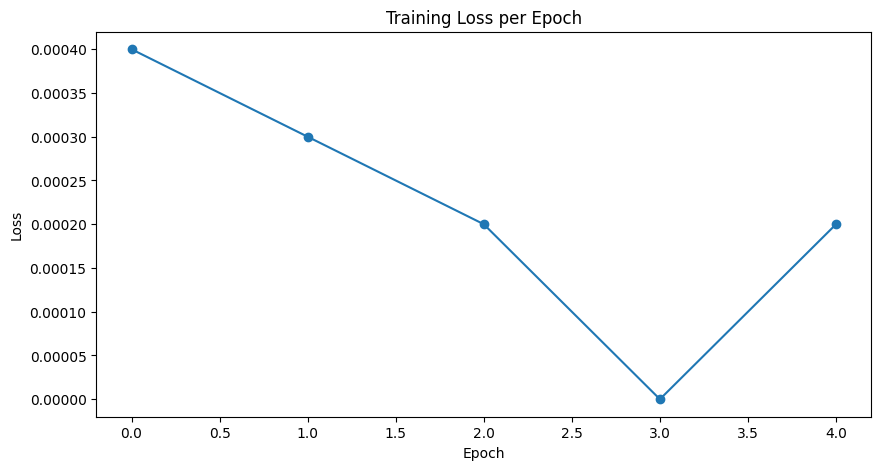

In [ ]:
# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(eval_results)


# Plot the loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(loss_logger.epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.show()


<ipython-input-25-1db2e36cdd4b>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.000100,0.001975,0.999516,0.999503,0.999492,0.998995
2,0.000100,0.001929,0.999523,0.999532,0.999519,0.999051
3,0.000100,0.001777,0.999558,0.999591,0.999570,0.999161
4,0.000000,0.001724,0.999624,0.999615,0.999600,0.999215
5,0.000200,0.001768,0.999616,0.999605,0.999591,0.999196


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.74      0.85        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.76      0.97      0.85       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.88      0.94      0.91        16
  I-NAME_STUDENT       0.92      1.00      0.96       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.46      0.47      0.46    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       0.89      0.94      0.91        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.78      0.94      0.85       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.84      1.00      0.91        16
  I-NAME_STUDENT       0.90      1.00      0.95       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.45      0.49      0.47    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       0.97      0.88      0.92        34
     I-PHONE_NUM       0.00      0.00      0.00         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.81      0.92      0.86       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.84      1.00      0.91        16
  I-NAME_STUDENT       0.94      1.00      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.46      0.48      0.47    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.91      0.95        34
     I-PHONE_NUM       1.00      0.11      0.20         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.82      0.92      0.87       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.89      1.00      0.94        16
  I-NAME_STUDENT       0.94      1.00      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.55      0.50      0.49    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

      B-USERNAME       0.00      0.00      0.00         0
         B-EMAIL       1.00      1.00      1.00         7
               O       1.00      1.00      1.00    204733
        B-ID_NUM       1.00      0.88      0.94        34
     I-PHONE_NUM       1.00      0.11      0.20         9
     B-PHONE_NUM       0.00      0.00      0.00         3
  B-NAME_STUDENT       0.82      0.93      0.87       190
I-STREET_ADDRESS       0.00      0.00      0.00         0
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.88      0.94      0.91        16
  I-NAME_STUDENT       0.94      1.00      0.97       151
  I-URL_PERSONAL       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.55      0.49      0.49    205143
    weighted avg       1.00      1.00      1.00    205143



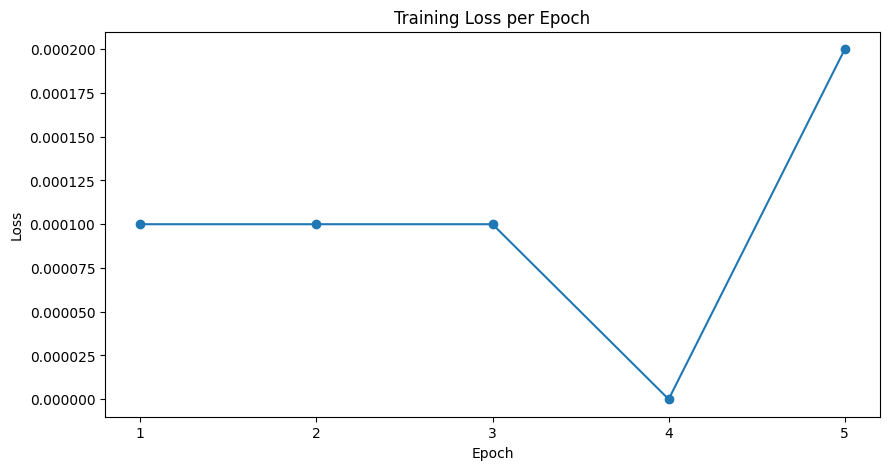

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries and 'loss' key exists
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the loss logger callback
loss_logger = LossLoggerCallback()

# Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",               # Use eval_strategy to avoid deprecation warning
    save_strategy="epoch",               # Save model at each epoch
    load_best_model_at_end=True,         # Load the best model after training
    metric_for_best_model="loss",        # Use loss to identify the best model
    greater_is_better=False,             # Lower loss is better
    learning_rate=1e-5,                  # Reduced learning rate for smoother convergence
    per_device_train_batch_size=2,       # Adjust batch size as needed
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,       # Simulate larger batch size
    num_train_epochs=5,                  # Set the desired number of epochs
    weight_decay=0.01,                   # Regularization to avoid overfitting
    fp16=True,                           # Mixed precision for memory optimization
    max_grad_norm=1.0,                   # Gradient clipping to stabilize training
    logging_strategy="steps",            # Log at each step
    logging_steps=10,                    # Adjust logging frequency as needed
)

# Add an early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize the trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, loss_logger]  # Include early stopping and loss logger
)

# Start training
trainer.train()

# Plot the epoch losses after training, with epochs starting from 1
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_logger.epoch_losses) + 1), loss_logger.epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.xticks(range(1, len(loss_logger.epoch_losses) + 1))  # Set x-axis ticks to match epoch numbers
plt.show()


### Create a Custom DeBERTa Model with Dropout

In [20]:
from transformers import DebertaForTokenClassification
import torch.nn as nn

# Custom DeBERTa Model with Dropout
class CustomDebertaForTokenClassification(DebertaForTokenClassification):
    def __init__(self, config, dropout_rate=0.3):
        super().__init__(config)
        self.deberta = self.deberta  # Base DeBERTa model
        self.dropout = nn.Dropout(p=dropout_rate)  # Custom dropout rate
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)  # Classification layer

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        # Pass inputs through the DeBERTa model
        outputs = self.deberta(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # Apply dropout and pass through classifier
        sequence_output = self.dropout(outputs[0])
        logits = self.classifier(sequence_output)

        # Compute loss if labels are provided
        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits.view(-1, self.config.num_labels), labels.view(-1))
            return (loss, logits)

        return logits


### Model Initialization

In [21]:
from transformers import AutoConfig, DebertaTokenizerFast

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")

# Load configuration
config = AutoConfig.from_pretrained(
    "microsoft/deberta-v3-base",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

# Initialize the custom model with dropout
model = CustomDebertaForTokenClassification(config, dropout_rate=0.3)
model.to(device)  # Move to GPU/CPU


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


CustomDebertaForTokenClassification(
  (deberta): DebertaModel(
    (embeddings): DebertaEmbeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): DebertaLayerNorm()
      (dropout): StableDropout()
    )
    (encoder): DebertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaLayer(
          (attention): DebertaAttention(
            (self): DisentangledSelfAttention(
              (in_proj): Linear(in_features=768, out_features=2304, bias=False)
              (pos_dropout): StableDropout()
              (pos_proj): Linear(in_features=768, out_features=768, bias=False)
              (pos_q_proj): Linear(in_features=768, out_features=768, bias=True)
              (dropout): StableDropout()
            )
            (output): DebertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): DebertaLayerNorm()
              (dropout): StableDropout()
            )
          )
       

In [22]:
# Define data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

In [23]:
# Define Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha, (float, int)):
            self.alpha = torch.Tensor([alpha, 1 - alpha])
        if isinstance(alpha, list):
            self.alpha = torch.Tensor(alpha)

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-BCE_loss)
        F_loss = ((1 - pt) ** self.gamma) * BCE_loss
        return F_loss.mean()

In [24]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_labels = [[id2label[label] for label in doc if label != -100] for doc in labels]
    true_predictions = [
        [id2label[pred] for pred, label in zip(doc, labels[i]) if label != -100]
        for i, doc in enumerate(predictions)
    ]

    # Flatten the lists
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    true_predictions_flat = [item for sublist in true_predictions for item in sublist]

    # Calculate metrics
    results = precision_recall_fscore_support(true_labels_flat, true_predictions_flat, average='weighted')

    # Compute classification report
    class_report = classification_report(
        true_labels_flat, true_predictions_flat, labels=all_labels, zero_division=0  # Explicitly set labels and handle zero division
    )

    print("Classification Report:\n", class_report)
    return {
        "precision": results[0],
        "recall": results[1],
        "f1": results[2],
        "accuracy": (results[2] * results[1])
    }



In [25]:
from transformers import TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the callback
loss_logger = LossLoggerCallback()

### Custom Model in the Trainer

In [26]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback, TrainerCallback
import matplotlib.pyplot as plt

# Custom callback to log loss at the end of each epoch
class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.epoch_losses = []

    def on_epoch_end(self, args, state, control, **kwargs):
        # Check if log_history has entries and 'loss' key exists
        if state.log_history and 'loss' in state.log_history[-1]:
            # Store the loss of the current epoch
            self.epoch_losses.append(state.log_history[-1]['loss'])
        else:
            print("Warning: No loss logged for this epoch.")

# Initialize the loss logger callback
loss_logger = LossLoggerCallback()

# Define training arguments with optimizations
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",               # Use eval_strategy to avoid deprecation warning
    save_strategy="epoch",               # Save model at each epoch
    load_best_model_at_end=True,         # Load the best model after training
    metric_for_best_model="loss",        # Use loss to identify the best model
    greater_is_better=False,             # Lower loss is better
    learning_rate=1e-5,                  # Reduced learning rate for smoother convergence
    per_device_train_batch_size=2,       # Adjust batch size as needed
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,       # Simulate larger batch size
    num_train_epochs=5,                  # Set the desired number of epochs
    weight_decay=0.01,                   # Regularization to avoid overfitting
    fp16=True,                           # Mixed precision for memory optimization
    max_grad_norm=1.0,                   # Gradient clipping to stabilize training
    logging_strategy="steps",            # Log at each step
    logging_dir='./logs',                   # Directory for logging (optional)
    logging_steps=10,                    # Adjust logging frequency as needed
    report_to='none',                       # Disable external logging tools
)

# Add an early stopping callback
early_stopping_callback = EarlyStoppingCallback(early_stopping_patience=2)

# Initialize the trainer with the callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback, loss_logger]  # Include early stopping and loss logger
)
model = CustomDebertaForTokenClassification(config, dropout_rate=0.4)

# Start training
trainer.train()

<ipython-input-26-29cac60c50b8>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.014300,0.016166,0.996007,0.998001,0.997003,0.995010
2,0.011700,0.014019,0.997231,0.998055,0.997266,0.995326
3,0.009600,0.013836,0.997254,0.998070,0.997366,0.995440
4,0.007200,0.013279,0.997103,0.998036,0.997390,0.995431
5,0.008900,0.013311,0.997073,0.998006,0.997396,0.995408


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

     I-PHONE_NUM       0.00      0.00      0.00         9
        B-ID_NUM       0.00      0.00      0.00        34
  I-NAME_STUDENT       0.00      0.00      0.00       151
  I-URL_PERSONAL       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.00      0.00      0.00       190
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.00      0.00      0.00        16
     B-PHONE_NUM       0.00      0.00      0.00         3
               O       1.00      1.00      1.00    204733
         B-EMAIL       0.00      0.00      0.00         7
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.08      0.08      0.08    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

     I-PHONE_NUM       0.00      0.00      0.00         9
        B-ID_NUM       0.00      0.00      0.00        34
  I-NAME_STUDENT       0.91      0.07      0.12       151
  I-URL_PERSONAL       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.35      0.05      0.08       190
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.64      1.00      0.78        16
     B-PHONE_NUM       0.00      0.00      0.00         3
               O       1.00      1.00      1.00    204733
         B-EMAIL       0.00      0.00      0.00         7
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.24      0.18      0.17    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

     I-PHONE_NUM       0.00      0.00      0.00         9
        B-ID_NUM       0.00      0.00      0.00        34
  I-NAME_STUDENT       0.82      0.09      0.17       151
  I-URL_PERSONAL       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.37      0.09      0.14       190
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.91      0.62      0.74        16
     B-PHONE_NUM       0.00      0.00      0.00         3
               O       1.00      1.00      1.00    204733
         B-EMAIL       0.00      0.00      0.00         7
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.26      0.15      0.17    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

     I-PHONE_NUM       0.00      0.00      0.00         9
        B-ID_NUM       0.00      0.00      0.00        34
  I-NAME_STUDENT       0.55      0.11      0.18       151
  I-URL_PERSONAL       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.38      0.11      0.17       190
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.85      0.69      0.76        16
     B-PHONE_NUM       0.00      0.00      0.00         3
               O       1.00      1.00      1.00    204733
         B-EMAIL       0.00      0.00      0.00         7
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.23      0.16      0.18    205143
    weighted avg       1.00      1.00      1.00    205143



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                   precision    recall  f1-score   support

     I-PHONE_NUM       0.00      0.00      0.00         9
        B-ID_NUM       0.00      0.00      0.00        34
  I-NAME_STUDENT       0.50      0.12      0.19       151
  I-URL_PERSONAL       0.00      0.00      0.00         0
      B-USERNAME       0.00      0.00      0.00         0
  B-NAME_STUDENT       0.34      0.11      0.17       190
B-STREET_ADDRESS       0.00      0.00      0.00         0
  B-URL_PERSONAL       0.64      1.00      0.78        16
     B-PHONE_NUM       0.00      0.00      0.00         3
               O       1.00      1.00      1.00    204733
         B-EMAIL       0.00      0.00      0.00         7
I-STREET_ADDRESS       0.00      0.00      0.00         0

        accuracy                           1.00    205143
       macro avg       0.21      0.19      0.18    205143
    weighted avg       1.00      1.00      1.00    205143



TrainOutput(global_step=750, training_loss=0.022703802555799485, metrics={'train_runtime': 2192.9905, 'train_samples_per_second': 2.736, 'train_steps_per_second': 0.342, 'total_flos': 3657683091456000.0, 'train_loss': 0.022703802555799485, 'epoch': 5.0})

In [27]:
# Extract training and validation loss
training_losses = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
validation_losses = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]

# Ensure both lists have the same length
if len(validation_losses) < len(training_losses):
    training_losses = training_losses[:len(validation_losses)]  # Trim training losses to match validation losses
elif len(validation_losses) > len(training_losses):
    validation_losses = validation_losses[:len(training_losses)]  # Trim validation losses to match training losses


In [28]:
print("Training Losses:", len(training_losses))
print("Validation Losses:", len(validation_losses))

Training Losses: 5
Validation Losses: 5


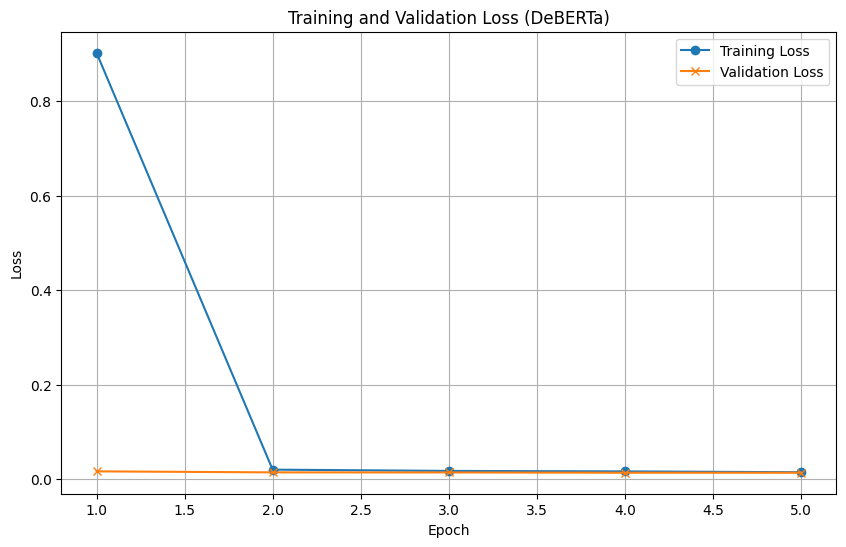

In [29]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(training_losses) + 1), training_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (DeBERTa)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Load test dataset
test_dataset = datasets.load_dataset('json', data_files='/content/drive/MyDrive/Dataset/pii-detection-removal-from-educational-data/test.json')['train']

def tokenize_test_set(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=1536,
        return_offsets_mapping=True
    )

    batch_original_tokens = []
    batch_tokenized_tokens = []
    batch_input_ids = []
    batch_attention_masks = []
    batch_token_type_ids = []
    batch_offset_mappings = []  # New line to store offset mappings

    for i in range(len(examples["tokens"])):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        original_tokens = examples["tokens"][i]
        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized_inputs["input_ids"][i])

        original_token_list = []
        tokenized_token_list = []
        input_id_list = []
        attention_mask_list = []
        token_type_id_list = []

        for j, word_idx in enumerate(word_ids):
            current_original_token = '' if word_idx is None else original_tokens[word_idx]

            original_token_list.append(current_original_token)
            tokenized_token_list.append(tokenized_tokens[j])
            input_id_list.append(tokenized_inputs["input_ids"][i][j])
            attention_mask_list.append(tokenized_inputs["attention_mask"][i][j])
            if "token_type_ids" in tokenized_inputs:
                token_type_id_list.append(tokenized_inputs["token_type_ids"][i][j])
            else:
                token_type_id_list.append(0)

        batch_original_tokens.append(original_token_list)
        batch_tokenized_tokens.append(tokenized_token_list)
        batch_input_ids.append(input_id_list)
        batch_attention_masks.append(attention_mask_list)
        batch_token_type_ids.append(token_type_id_list)
        # Append offset_mapping for the current sample
        batch_offset_mappings.append(tokenized_inputs['offset_mapping'][i])

    return {
        "original_tokens": batch_original_tokens,
        "tokenized_tokens": batch_tokenized_tokens,
        "input_ids": batch_input_ids,
        "attention_mask": batch_attention_masks,
        "token_type_ids": batch_token_type_ids,
        "offset_mapping": batch_offset_mappings,
    }

test_dataset = test_dataset.map(tokenize_test_set, batched=True)

# List of columns to keep
columns_to_keep = ['document', 'input_ids', 'attention_mask', 'token_type_ids']
test_dataset = test_dataset.remove_columns([col for col in test_dataset.column_names if col not in columns_to_keep])
# Define the confidence threshold
confidence_threshold = 0.95

# Predict on test dataset
test_predictions = trainer.predict(test_dataset)
pred_probs = test_predictions.predictions
preds = np.argmax(pred_probs, axis=2)
max_probs = np.max(pred_probs, axis=2)

# Create submission file
submission = []

for i, doc in enumerate(pred_probs):
    word_ids = test_dataset[i]['input_ids']
    for j, word_id in enumerate(word_ids):
        if word_id != tokenizer.pad_token_id:
            row_id = len(submission)
            document_id = test_dataset[i]['document']
            token_id = j
            pred_label = id2label[preds[i][j]]
            if pred_label != 'O' and max_probs[i][j] >= confidence_threshold:  # Exclude outside labels and apply threshold
                submission.append([row_id, document_id, token_id, pred_label])

submission_df = pd.DataFrame(submission, columns=["row_id", "document", "token", "label"])

# Save to CSV
submission_df.to_csv('submission.csv', index=False)

print("Submission file created successfully!")
print(submission_df)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Submission file created successfully!
    row_id  document  token           label
0        0         7     11  B-NAME_STUDENT
1        1         7     12  I-NAME_STUDENT
2        2         7     13  I-NAME_STUDENT
3        3         7    460  B-NAME_STUDENT
4        4         7    461  I-NAME_STUDENT
5        5         7    462  I-NAME_STUDENT
6        6         7    706  B-NAME_STUDENT
7        7         7    707  I-NAME_STUDENT
8        8         7    708  I-NAME_STUDENT
9        9        10      1  B-NAME_STUDENT
10      10        10      2  I-NAME_STUDENT
11      11        10    433  B-NAME_STUDENT
12      12        10    434  I-NAME_STUDENT
13      13        16      4  B-NAME_STUDENT
14      14        16      5  I-NAME_STUDENT
15      15        16      6  I-NAME_STUDENT
16      16        20      5  B-NAME_STUDENT
17      17        20      6  B-NAME_STUDENT
18      18        20      7  I-NAME_STUDENT
19      19        20      8  I-NAME_STUDENT
20      20        56      8  B-NAME_ST